# <center>Home Credit Default Risk</center>

# Table of contents:
- <a href='#5'>5. Features Engineering</a> 
    - <a href='#5.1'>5.1 Merging bureau and bureau_balance</a> 
        - <a href='#5.1.1'>5.1.1 bureau_balance</a>     
        - <a href='#5.1.2'>5.1.2 bureau</a>  



-Source: 
- https://www.kaggle.com/c/home-credit-defau

# <a id='1'>1. Introduction/ Use Cases</a>
* Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

* Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

* While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# <a id='2'>2. Data description</a>
## Main data: info about loan and loan application at application time
* **application_train/application_test**: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid. 

## A variety of alternative data:
* **bureau**: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.

* **bureau_balance**: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 

* **previous_application**: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV. 

* **POS_CASH_BALANCE**: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

* **credit_card_balance**: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

* **installments_payment**: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

## Columns description:
* **HomeCredit_columns_description**: contains descriptions for the columns in the 7 various data files.

## Diagram:
This diagram shows how all of the data is related:

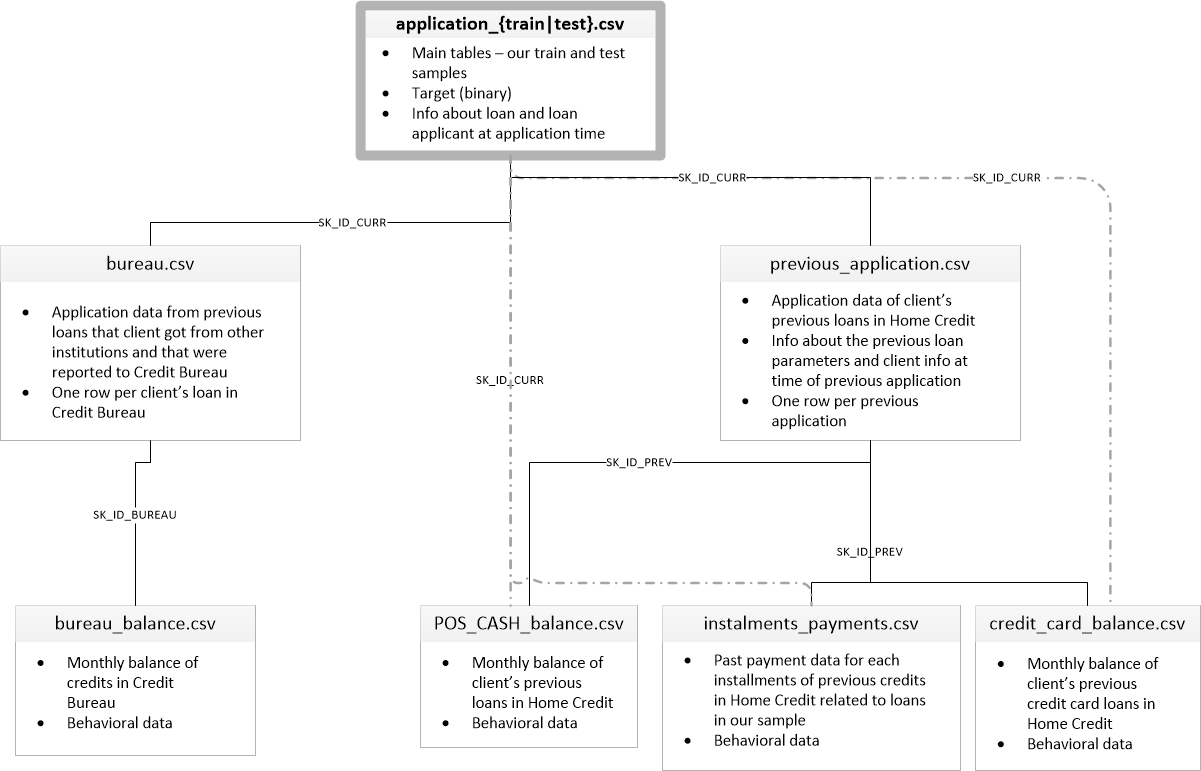


# <a id='5'>5. Feature Engineering</a>

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

#import gc

import pickle

In [126]:
path = r"C:\Khoa\School\Home_Credit_Default_Risk\data/"
application_train = pd.read_csv(path + "application_train.csv")
application_test = pd.read_csv(path + "application_test.csv")
print("application_train's shape: ", application_train.shape)
print("application_test's shape: ", application_test.shape)

application_train's shape:  (307511, 122)
application_test's shape:  (48744, 121)


In [4]:
bureau = pd.read_csv(path + "bureau.csv")
bureau_balance = pd.read_csv(path + "bureau_balance.csv")

POS_CASH_balance = pd.read_csv(path + "POS_CASH_balance.csv")
credit_card_balance = pd.read_csv(path + "credit_card_balance.csv")

previous_application = pd.read_csv(path + "previous_application.csv")
installments_payments = pd.read_csv(path + "installments_payments.csv")


In [5]:
print("bureau's shape: ", bureau.shape)
print("bureau_balance's shape: ", bureau_balance.shape)
print("POS_CASH_balance's shape: ", POS_CASH_balance.shape)
print("credit_card_balance's shape: ", credit_card_balance.shape)
print("previous_application's shape: ", previous_application.shape)
print("installments_payments's shape: ", installments_payments.shape)


bureau's shape:  (1716428, 17)
bureau_balance's shape:  (27299925, 3)
POS_CASH_balance's shape:  (10001358, 8)
credit_card_balance's shape:  (3840312, 23)
previous_application's shape:  (1670214, 37)
installments_payments's shape:  (13605401, 8)


## <a id='5.1'>5.1 Merging bureau and bureau_balance</a>

### <a id='5.1.1'>5.1.1 bureau_balance</a>
- **Statement**: Expecting to merging 'bureau_balance' to 'bureau' through 'SK_ID_BUREAU'.
- **Challenges**: bureau_balance's shape:  **(27299925, 3)**. The information detail at 'monthly cashflow' level ==> need to be aggregated to fit 'loan level' of **bureau** table.
- Weighted 'STATUS' by total number of 'MONTHS_BALANCE' belonging to that 'STATUS'

In [27]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [7]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [10]:
bureau_balance, bureau_balance_cat = one_hot_encoder(bureau_balance, nan_as_category = True)

In [12]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,STATUS_nan
0,5715448,0,0,0,0,0,0,0,1,0,0
1,5715448,-1,0,0,0,0,0,0,1,0,0
2,5715448,-2,0,0,0,0,0,0,1,0,0
3,5715448,-3,0,0,0,0,0,0,1,0,0
4,5715448,-4,0,0,0,0,0,0,1,0,0


In [14]:
bureau_balance_aggregations = {'MONTHS_BALANCE': ['size']}
for col in bureau_balance_cat:
    bureau_balance_aggregations[col] = ['mean']
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bureau_balance_aggregations)

In [16]:
# Transform column names
bureau_balance_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bureau_balance_agg.columns.tolist()])

In [18]:
bureau_balance_agg.head()

,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN
SK_ID_BUREAU,,,,,,,,,,
5001709,97,0.000000,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402,0
5001710,83,0.060241,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446,0
5001711,4,0.750000,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,0
5001712,19,0.526316,0.0,0.0,0.0,0.0,0.0,0.473684,0.000000,0
5001713,22,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0


- **Colunm description**: Status of Credit Bureau loan [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off ] )

In [20]:
print("bureau_balance_agg's shape: ", bureau_balance_agg.shape)

bureau_balance_agg's shape:  (817395, 10)


- from bureau_balance's shape:  (27299925, 3) was transformed to bureau_balance_agg's shape:  (817395, 10)

### <a id='5.1.2'>5.1.2 bureau</a>

In [23]:
# merging 'bureau_balance_agg' to 'bureau' through 'SK_ID_BUREAU'.
bureau = bureau.join(bureau_balance_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)

In [46]:
bureau.shape

(1716428, 26)

In [51]:
bureau.head()

,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,...,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN
0,215354,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=True)

In [53]:
num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }

In [55]:
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bureau_balance_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

In [56]:
cat_aggregations

{'CREDIT_ACTIVE_Active': ['mean'],
 'CREDIT_ACTIVE_Bad debt': ['mean'],
 'CREDIT_ACTIVE_Closed': ['mean'],
 'CREDIT_ACTIVE_Sold': ['mean'],
 'CREDIT_ACTIVE_nan': ['mean'],
 'CREDIT_CURRENCY_currency 1': ['mean'],
 'CREDIT_CURRENCY_currency 2': ['mean'],
 'CREDIT_CURRENCY_currency 3': ['mean'],
 'CREDIT_CURRENCY_currency 4': ['mean'],
 'CREDIT_CURRENCY_nan': ['mean'],
 'CREDIT_TYPE_Another type of loan': ['mean'],
 'CREDIT_TYPE_Car loan': ['mean'],
 'CREDIT_TYPE_Cash loan (non-earmarked)': ['mean'],
 'CREDIT_TYPE_Consumer credit': ['mean'],
 'CREDIT_TYPE_Credit card': ['mean'],
 'CREDIT_TYPE_Interbank credit': ['mean'],
 'CREDIT_TYPE_Loan for business development': ['mean'],
 'CREDIT_TYPE_Loan for purchase of shares (margin lending)': ['mean'],
 'CREDIT_TYPE_Loan for the purchase of equipment': ['mean'],
 'CREDIT_TYPE_Loan for working capital replenishment': ['mean'],
 'CREDIT_TYPE_Microloan': ['mean'],
 'CREDIT_TYPE_Mobile operator loan': ['mean'],
 'CREDIT_TYPE_Mortgage': ['mean'],
 '

In [57]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [59]:
bureau_agg.head()

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,BURO_CREDIT_TYPE_nan_MEAN,BURO_STATUS_0_MEAN_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_4_MEAN_MEAN,BURO_STATUS_5_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN,BURO_STATUS_nan_MEAN_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0,0.336651,0.007519,0.0,0.0,0.0,0.0,0.441240,0.214590,0.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0,0.406960,0.255682,0.0,0.0,0.0,0.0,0.175426,0.161932,0.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0,0.735043,0.000000,0.0,0.0,0.0,0.0,0.128205,0.136752,0.0


In [60]:
bureau_agg.columns

Index(['BURO_DAYS_CREDIT_MIN', 'BURO_DAYS_CREDIT_MAX', 'BURO_DAYS_CREDIT_MEAN',
       'BURO_DAYS_CREDIT_VAR', 'BURO_DAYS_CREDIT_ENDDATE_MIN',
       'BURO_DAYS_CREDIT_ENDDATE_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
       'BURO_DAYS_CREDIT_UPDATE_MEAN', 'BURO_CREDIT_DAY_OVERDUE_MAX',
       'BURO_CREDIT_DAY_OVERDUE_MEAN', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
       'BURO_AMT_CREDIT_SUM_MAX', 'BURO_AMT_CREDIT_SUM_MEAN',
       'BURO_AMT_CREDIT_SUM_SUM', 'BURO_AMT_CREDIT_SUM_DEBT_MAX',
       'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'BURO_AMT_CREDIT_SUM_DEBT_SUM',
       'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN', 'BURO_AMT_CREDIT_SUM_LIMIT_MEAN',
       'BURO_AMT_CREDIT_SUM_LIMIT_SUM', 'BURO_AMT_ANNUITY_MAX',
       'BURO_AMT_ANNUITY_MEAN', 'BURO_CNT_CREDIT_PROLONG_SUM',
       'BURO_MONTHS_BALANCE_SIZE_MEAN', 'BURO_MONTHS_BALANCE_SIZE_SUM',
       'BURO_CREDIT_ACTIVE_Active_MEAN', 'BURO_CREDIT_ACTIVE_Bad debt_MEAN',
       'BURO_CREDIT_ACTIVE_Closed_MEAN', 'BURO_CREDIT_ACTIVE_Sold_MEAN',
       'BURO_C

In [90]:
bureau_agg.shape

(305811, 60)

In [127]:
application_train = application_train.join(bureau_agg, how='left', on='SK_ID_CURR')
application_test = application_test.join(bureau_agg, how='left', on='SK_ID_CURR')

In [128]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,BURO_CREDIT_TYPE_nan_MEAN,BURO_STATUS_0_MEAN_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_4_MEAN_MEAN,BURO_STATUS_5_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN,BURO_STATUS_nan_MEAN_MEAN
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.40696,0.255682,0.0,0.0,0.0,0.0,0.175426,0.161932,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
application_train.shape

(307511, 182)

In [130]:
application_test.shape

(48744, 181)

In [131]:
# one-hot encoding of categorical variables
application_train = pd.get_dummies(application_train)
application_test = pd.get_dummies(application_test)

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 306)
Testing Features shape:  (48744, 302)


In [132]:
train_labels = application_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes. 
# axis = 1 to align the dataframes based on the columns and not on the rows!

application_train, application_test = application_train.align(application_test, join = 'inner', axis = 1)

# Add the target back in
application_train['TARGET'] = train_labels

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 303)
Testing Features shape:  (48744, 302)


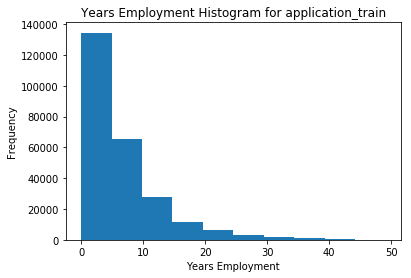

In [140]:
# Replace the anomalous values with nan
application_train['DAYS_EMPLOYED_ANOM'] = application_test["DAYS_EMPLOYED"] == 365243
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

(application_train['DAYS_EMPLOYED']/-365).plot.hist(title = 'Years Employment Histogram for application_train')
plt.xlabel('Years Employment')
plt.show()

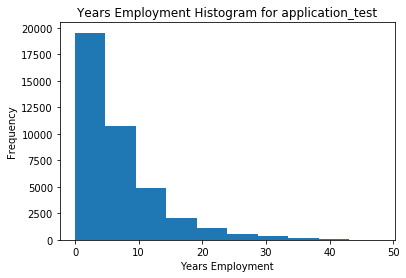

In [141]:
application_test['DAYS_EMPLOYED_ANOM'] = application_test["DAYS_EMPLOYED"] == 365243
application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

(application_test['DAYS_EMPLOYED']/-365).plot.hist(title = 'Years Employment Histogram for application_test')
plt.xlabel('Years Employment')
plt.show()

In [142]:
from sklearn.preprocessing import MinMaxScaler, Imputer

In [143]:
# Drop the target from the training data and then copy to train data
if 'TARGET' in application_train or 'SK_ID_CURR' in application_train:
    train = application_train.drop(columns = ['TARGET', 'SK_ID_CURR'])
else:
    train = application_train.copy()

In [144]:
# Drop the target from the training data and then copy to train data
if 'SK_ID_CURR' in application_train:
    test = application_test.drop(columns = ['SK_ID_CURR'])
else:
    test = application_test.copy()

In [145]:
test.shape

(48744, 302)

In [146]:
train.shape

(307511, 302)

In [147]:
# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

In [148]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Scaler on the training data
scaler.fit(train)

# Transform both training and testing data
train = scaler.transform(train)
test = scaler.transform(test)

In [149]:
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 302)
Testing data shape:  (48744, 302)


In [150]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression()

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [152]:
import pickle
# save the model to disk
FE_LogisticRegression_model = 'FE_LogisticRegression_model.sav'
pickle.dump(log_reg, open(FE_LogisticRegression_model, 'wb'))

In [153]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [154]:
# Submission dataframe
submit = application_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

C:\Users\kevin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,SK_ID_CURR,TARGET
0,100001,0.051724
1,100005,0.191947
2,100013,0.029579
3,100028,0.029139
4,100038,0.136609


In [156]:
# Save the submission to a csv file
submit.to_csv('fe_log_reg.csv', index = False)

- The logistic regression feturing with bureau and bureau_balance should score around **0.74263** when submitted. 
- Improve from **0.73797** baseline.

In [157]:
# Feature names
features = application_train.drop(columns = ['TARGET','SK_ID_CURR']).columns

In [159]:
from sklearn.ensemble import RandomForestClassifier
# set n_estimators = 100, random_state = 50 to improve predicting performance. 
#default values: n_estimators = 10, random_state = None
random_forest_1 = RandomForestClassifier(n_estimators = 100, random_state = 50)
# Train on the training data
random_forest_1.fit(train, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [161]:
# save the model to disk
fe_RandomForestClassifier_1_model = 'fe_RandomForestClassifier_model.sav'
pickle.dump(random_forest_1, open(fe_RandomForestClassifier_1_model, 'wb'))

In [162]:
# Make predictions
# Make sure to select the second column only
random_frorest_pred_1 = random_forest_1.predict_proba(test)[:, 1]

# Make a submission dataframe
random_forest_submit_1 = application_test[['SK_ID_CURR']]
random_forest_submit_1['TARGET'] = random_frorest_pred_1

# Save the submission dataframe
random_forest_submit_1.to_csv('fe_random_forest.csv', index = False)

C:\Users\kevin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



0.70001

In [163]:
# Extract feature importances
feature_importance_values_1 = random_forest_1.feature_importances_
feature_importances_1 = pd.DataFrame({'feature': features, 'importance': feature_importance_values_1})

In [168]:
x, y = (list(x) for x in zip(*sorted(zip(feature_importances_1.importance, feature_importances_1.feature), 
                                                            reverse = False)))
trace = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 1000, height = 5000,
    yaxis=dict(
        showgrid=True,
        showline=True,
        showticklabels=True,
    ),
    margin=dict(
    l=300,
),
)


fig1 = go.Figure(data=[trace])
fig1['layout'].update(layout)
iplot(fig1, filename='plots')